* Simple Kick-Start DDPM models on Standford Car Dataset
* To download the Dataset, one can use this link (note that the torchvision dataset download does not work)
  ---  https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset

In [51]:
# Attemp to understand implementatino of DDPM through a notebook tutorial 
# first thing to solve is how to use the standford dataset of vehicle || Dataset out-of-data no longer maintained anymore -- download from Kaggle
# -- Alternatively we can consider moving MNIST? maybe not

In [1]:
import matplotlib.pyplot as plt
import torch

import os
import PIL
from PIL import Image as Image
import torchvision
from torchvision import transforms

# Download the dataset manually and load it with a custom dataset object
class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, root_path, transform = None):
        self.images = [os.path.join(root_path, file) for file in os.listdir(root_path)]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        image = Image.open(image_file).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # This is adding another batch dimension onto the readed image file
        return image[None]

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0].permute(1,2,0))



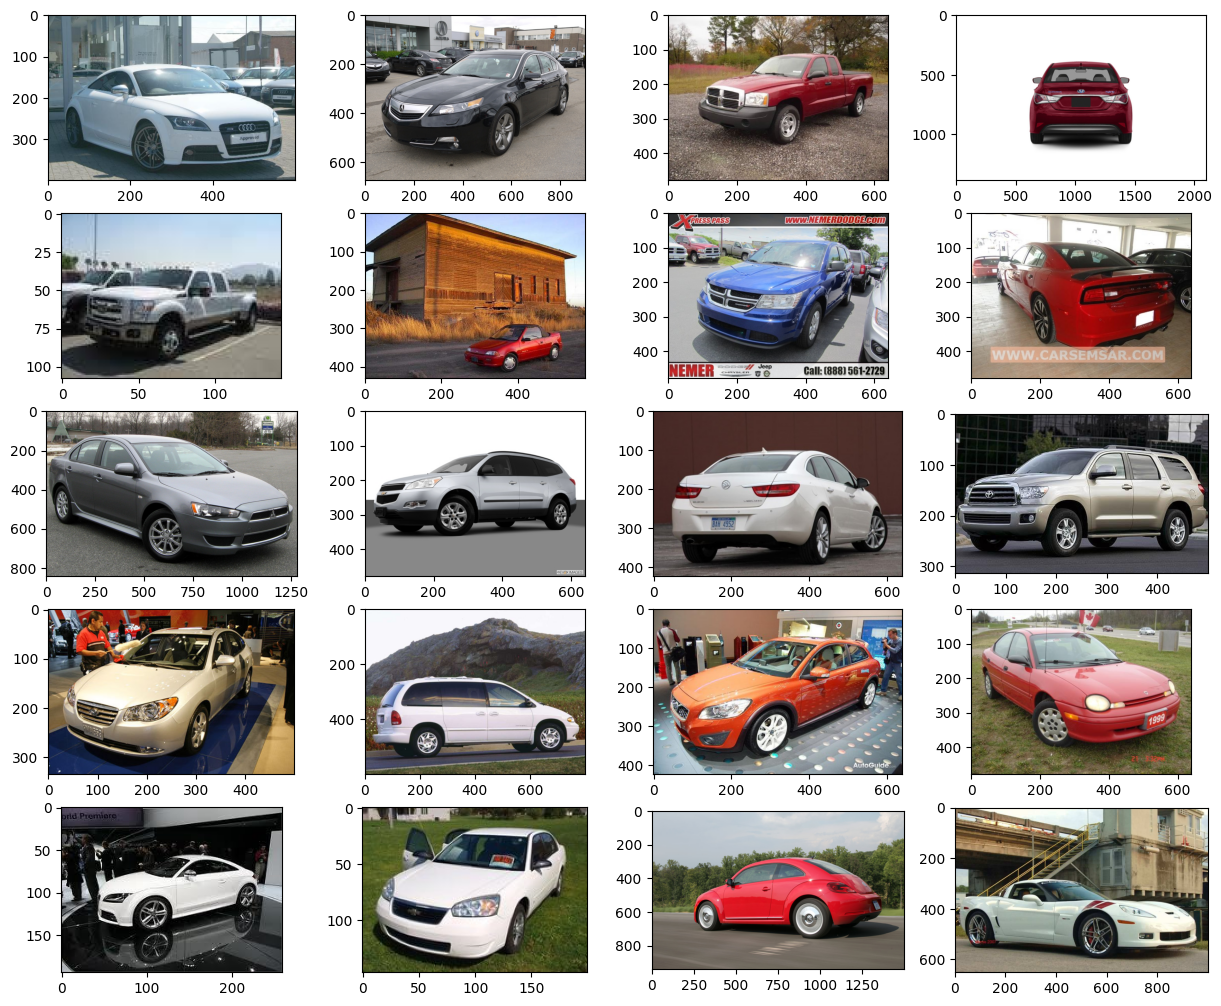

In [2]:
preprocess = transforms.Compose([transforms.ToTensor()])
data = StanfordCars(root_path='./stanford_cars/cars_train/cars_train', transform=preprocess)
show_images(data)

In [3]:
# 
import torch.nn.functional as F

# This is how we decide values on the beta_t (s)
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# So t here is 'A timestep', not a list of timesteps
def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    # this is the sqrt of cumprod of alphas, evaluated at timestep 't'
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    # this is the sqrt of one minus the cumprod of alphas, evaluated at timestep 't'
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
# Equation (3) : q(x_t-1 | x_t)'s variance values
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [4]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)
    train =  StanfordCars(root_path='./stanford_cars/cars_train/cars_train', transform=data_transform)
    test = StanfordCars(root_path='./stanford_cars/cars_test/cars_test', transform=data_transform)
    return torch.utils.data.ConcatDataset([train, test])
    
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/tmp/ipykernel_9792/1509478405.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


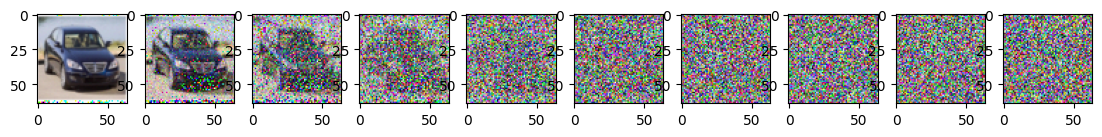

In [5]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [6]:
from torch import nn
import math

# Addition of time embedding dimension & addition to convolutionized input
# Time is embedded into tensors with shape of: (batch_size, time_emb_dim, ) -- Such embedding is done through sinudal positional embeddings
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)  # kernel size | stride | padding (kwargs ordering)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1) # kernel size | stride | padding (kwargs ordering)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):     
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions -- broadcast towards last two dimensions of tensor 'h'
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


# Time Embeddings here is taking place
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):  # An implicit assumption is that such dim should be an even number
        super().__init__()
        self.dim = dim

    def forward(self, time):        
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    Note that Downsample reduces spatial resolution while increase on channel sizes
    While the Upsample increase on spatial resolution while decrease on channel sizes
    Conv2d is essentially balancing bewteen spatial relution and channel sizes here 
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        # Due to the use of SkipConnections from Downsampling block towards Upsampling block, We need to set the input dimension of Upsampling Block to be double of the corresponding Downsampling Block input dimension
        for up in self.ups:
            # Pop out the first element in the residual inputs
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [7]:
def get_loss(model, x_0, t):
    # Given some noise process value epsilon, we can forward compute the x_t using standard formulas
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    # Then backward estimation of a noise processs with model is possible and we compute on the reconstruction loss accordingly 
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [8]:
@torch.no_grad()
# Again, this functional only tryies to compute x_0 the original noise-free image, and not the last-time-step less noisy image, since the noise process is already estimated by the model
# Addition of extra noise process with variance of (posterior variance t) value does not make any sense here -- this seems to be an mistake made by the author here -- although such functional is never se here anyway
def sample_timestep_bug(x, t):
    """
    Calls the model to predict the noise in the image (xt) (epsion(xt, t)) and returns 
    the denoised image (x0). 
    Applies noise to this image, if we are not in the last step yet.

    This SampleTimestep function is used for training -- Although I would think that all we really need is the Reconstruction loss of the noise estimate?
    Maybe in combination with the 
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        # Since we are just trying to compute X0, so given X0, there are no stochasticity at all here
        return model_mean
    else:
        # We add stochastic noise inside to make valid prediction on the denoised image
        noise = torch.randn_like(x)
        # I am not convinced on the usage of the posterior variance here: why is an extra noise process added with some variance, if we have already estimated on the noise process here?
        return model_mean + torch.sqrt(posterior_variance_t) * noise 



def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image (xt) (epsion(xt, t)) and returns 
    the denoised image (x0). 
    Applies noise to this image, if we are not in the last step yet.

    This SampleTimestep function is used for training -- Although I would think that all we really need is the Reconstruction loss of the noise estimate?
    Maybe in combination with the 
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    # posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        # Since we are just trying to compute X0, so given X0, there are no stochasticity at all here
        return model_mean
    else:
        # We add stochastic noise inside to make valid prediction on the denoised image
        # noise = torch.randn_like(x)
        return model_mean
        

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()    

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()